In [13]:
import os
import glob
import nibabel as nib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split


# Директории
BASE_DIR  = 'datasets/'
TRAIN_DIR = 'training/'
TEST_DIR  = 'testdata_website/'

# Имена
PREPROCESSED_DIR_NAME = 'preprocessed'
MASKS_DIR_NAME = 'masks'


# Зареждане на дейтасета
class MSLesionDataset(Dataset):
    def __init__(self, root_dir, modalities=('flair', 'mprage', 'pd', 't2'), mask_type='mask1'):
        self.samples = []
        self.modalities = modalities
        self.mask_type = mask_type

        # Откриване на всички trainingXX папки
        train_dirs = sorted(glob.glob(os.path.join(root_dir, 'training*')))
        for train_dir in train_dirs:
            preproc_dir = os.path.join(train_dir, PREPROCESSED_DIR_NAME)
            mask_dir = os.path.join(train_dir, MASKS_DIR_NAME)

            # търсят се всички примери в тази папка
            flair_files = sorted(glob.glob(os.path.join(preproc_dir, '*_flair_pp.nii')))

            for flair_path in flair_files:
                base_name = os.path.basename(flair_path).replace('_flair_pp.nii', '')

                sample = {
                    'modalities': [],
                    'mask': os.path.join(mask_dir, f'{base_name}_{mask_type}.nii')
                }

                valid = True
                for mod in modalities:
                    mod_path = os.path.join(preproc_dir, f'{base_name}_{mod}_pp.nii')
                    if not os.path.exists(mod_path):
                        valid = False
                        break
                    sample['modalities'].append(mod_path)

                if valid and os.path.exists(sample['mask']):
                    self.samples.append(sample)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample = self.samples[idx]

        mod_volumes = [nib.load(p).get_fdata() for p in sample['modalities']]
        image = np.stack(mod_volumes, axis=0)  # (C, H, W, D)
        image = np.transpose(image, (0, 3, 1, 2))  # (C, D, H, W) – нужно за CNN3D
        image = torch.from_numpy(image).float()
        image = image / image.max()

        mask = nib.load(sample['mask']).get_fdata()  # (H, W, D)
        mask = np.expand_dims(mask, axis=0)          # (1, H, W, D)
        mask = np.transpose(mask, (0, 3, 1, 2))      # (1, D, H, W)
        mask = torch.from_numpy(mask).float()

        return image, mask

In [14]:
# Зареждане на данните
dataset = MSLesionDataset(root_dir=BASE_DIR+TRAIN_DIR)

print("Общо примери:", len(dataset))

Общо примери: 21


In [15]:
# Извличане на статистики
img, msk = dataset[0]

lesion_volumes = []
mean_intensities = {mod: [] for mod in ['flair', 'mprage', 'pd', 't2']}

for i in range(len(dataset)):
    img, mask = dataset[i]
    lesion_volumes.append(mask.sum().item())
    for j, mod in enumerate(mean_intensities.keys()):
        mean_intensities[mod].append(img[j].mean().item())

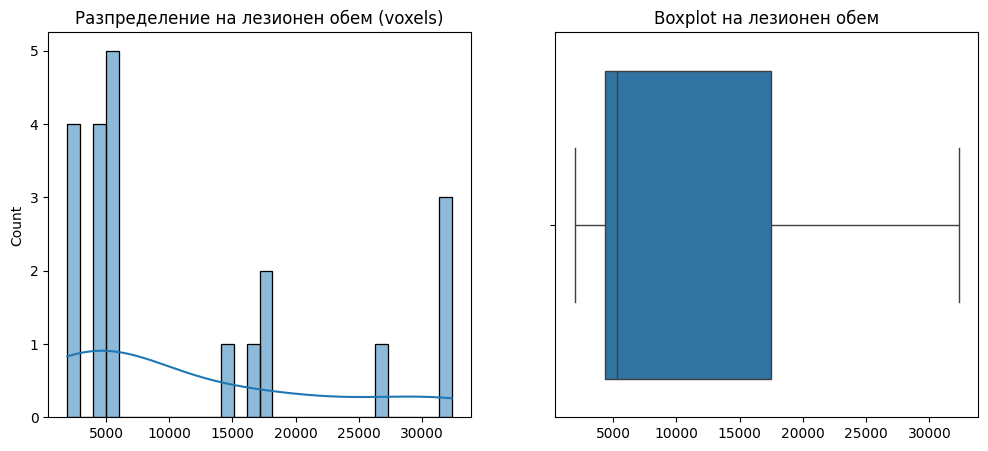

In [16]:
# Хистограма и boxplot на лезионен обем
plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
sns.histplot(lesion_volumes, bins=30, kde=True)
plt.title("Разпределение на лезионен обем (voxels)")

plt.subplot(1, 2, 2)
sns.boxplot(x=lesion_volumes)
plt.title("Boxplot на лезионен обем")
plt.show()


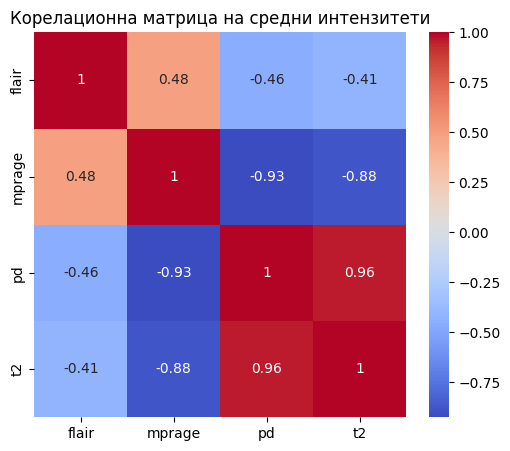

In [17]:
# Heatmap на корелациите между модалности
df = pd.DataFrame(mean_intensities)
corr = df.corr()

plt.figure(figsize=(6,5))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Корелационна матрица на средни интензитети")
plt.show()


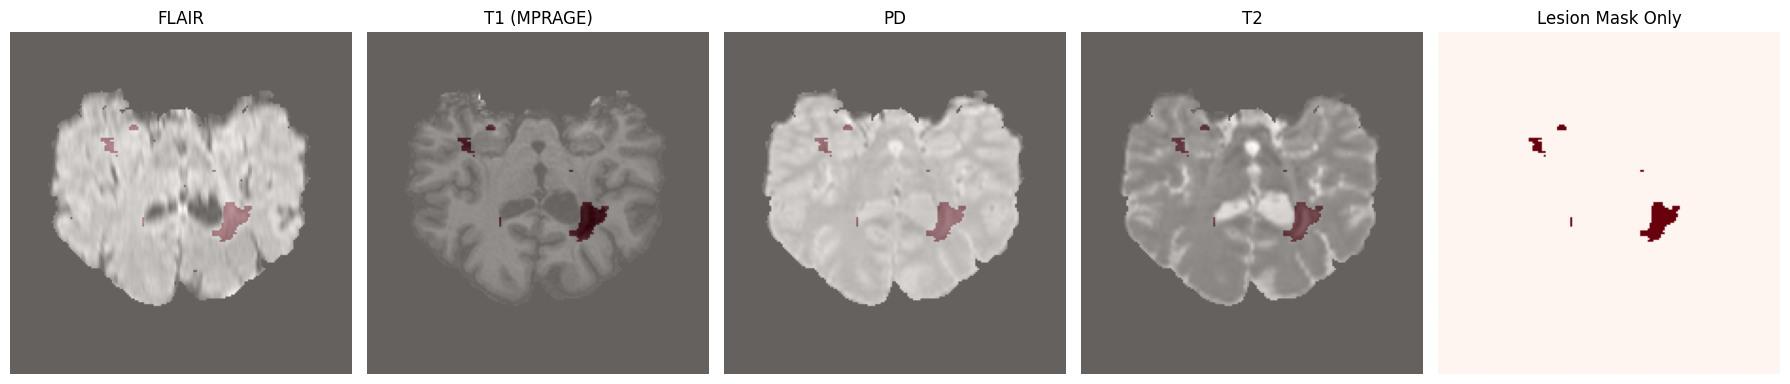

In [18]:
# Примерно изображение
example_img, example_mask = dataset[0]
slice_idx = example_img.shape[3] // 2  # централно ниво по дълбочина

fig, axes = plt.subplots(1, 5, figsize=(18,4))
mods = ['FLAIR', 'T1 (MPRAGE)', 'PD', 'T2']

for i in range(4):
    axes[i].imshow(example_img[i, :, :, slice_idx], cmap='gray')
    axes[i].imshow(example_mask[0, :, :, slice_idx], cmap='Reds', alpha=0.4)
    axes[i].set_title(mods[i])
    axes[i].axis('off')

axes[4].imshow(example_mask[0, :, :, slice_idx], cmap='Reds')
axes[4].set_title("Lesion Mask Only")
axes[4].axis('off')
plt.tight_layout()
plt.show()

In [50]:
# Класове за алгоритмите за ML

# Autoencoder
class Autoencoder3D(nn.Module):
    def __init__(self, in_channels=4, features=32):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv3d(in_channels, features, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv3d(features, features * 2, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv3d(features * 2, features * 4, 3, stride=2, padding=1),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose3d(features * 4, features * 2, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose3d(features * 2, features, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose3d(features, in_channels, 3, stride=2, padding=1, output_padding=1),

        )

    def forward(self, x):
        z = self.encoder(x)
        out = self.decoder(z)
        return out

# 3D CNN Classificator
class CNN3DReconstructor(nn.Module):
    def __init__(self):
        super(CNN3DReconstructor, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv3d(4, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool3d(2),

            nn.Conv3d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool3d(2)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose3d(32, 16, kernel_size=2, stride=2, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose3d(16, 4, kernel_size=2, stride=2, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder[0](x)
        x = self.encoder[1](x)
        x = self.encoder[2](x)

        x = self.encoder[3](x)
        x = self.encoder[4](x)
        x = self.encoder[5](x)

        x = self.decoder[0](x)
        x = self.decoder[1](x)
        x = self.decoder[2](x)
        x = self.decoder[3](x)

        return x


def center_crop_to_target(output, target):
    _, _, d1, h1, w1 = target.shape
    _, _, d2, h2, w2 = output.shape

    d_start = (d2 - d1) // 2
    h_start = (h2 - h1) // 2
    w_start = (w2 - w1) // 2

    cropped = output[:, :, d_start:d_start + d1,
                            h_start:h_start + h1,
                            w_start:w_start + w1]
    print(f"Cropped output shape: {cropped.shape}")
    return cropped

In [51]:
# Обучение и валидация на моделите

# Помощна функция за трениране
def train_model(model, optimizer, train_loader, loss_fn, device, n_epochs=10):
    model.to(device)
    model.train()
    for epoch in range(n_epochs):
        epoch_loss = 0
        for x, _ in train_loader:
            x = x.to(device)
            optimizer.zero_grad()
            output = model(x)
            output = center_crop_to_target(output, x)
            loss = loss_fn(output, x)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        avg_loss = epoch_loss / len(train_loader)
        print(f"[Epoch {epoch+1}] Train Loss: {avg_loss:.4f}")

# Помощна функция за валидация
def validate_model(model, val_loader, loss_fn, device):
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for x, _ in val_loader:
            x = x.to(device)
            output = model(x)
            output = center_crop_to_target(output, x)
            loss = loss_fn(output, x)
            val_loss += loss.item()
    avg_val_loss = val_loss / len(val_loader)
    print(f"Validation Loss: {avg_val_loss:.4f}")
    return avg_val_loss

# Помощна функция за изрязване на Output-a
def center_crop_to_target(output, target):
    _, _, d1, h1, w1 = target.shape
    _, _, d2, h2, w2 = output.shape

    d_start = (d2 - d1) // 2
    h_start = (h2 - h1) // 2
    w_start = (w2 - w1) // 2

    return output[:, :, d_start:d_start + d1,
                        h_start:h_start + h1,
                        w_start:w_start + w1]

In [67]:
# Подготовка
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_ds, batch_size=1, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=1, shuffle=False)

class DiceLoss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, inputs, targets, smooth=1):
        inputs = torch.sigmoid(inputs)
        inputs = inputs.reshape(-1)
        targets = targets.reshape(-1)

        intersection = (inputs * targets).sum()
        dice = (2. * intersection + smooth) / (inputs.sum() + targets.sum() + smooth)
        return 1 - dice

bce_loss = nn.BCEWithLogitsLoss()
dice_loss = DiceLoss()

def combined_loss(output, target):
    return 0.5 * bce_loss(output, target) + 0.5 * dice_loss(output, target)

loss_fn = combined_loss

# Инстанции на моделите 
autoencoder = Autoencoder3D().to(device)
cnn3d = CNN3DReconstructor().to(device)

# Помощен речник
models = {
    "autoencoder": {
        "model": autoencoder,
        "optimizer": torch.optim.Adam(autoencoder.parameters(), lr=1e-4)
    },
    "cnn3d": {
        "model": cnn3d,
        "optimizer": torch.optim.Adam(cnn3d.parameters(), lr=1e-4)
    }
}

# Тренировка, валидация и запазване
for name, components in models.items():
    model = components["model"]
    optimizer = components["optimizer"]

    print(f"\nTraining {name}...\n")
    train_model(model, optimizer, train_loader, loss_fn, device, n_epochs=50)
    print(f"Validating {name}...\n")
    validate_model(model, val_loader, loss_fn, device)

    torch.save(model.state_dict(), f"models/{name}_model.pth")


Training autoencoder...

[Epoch 1] Train Loss: 0.8158
[Epoch 2] Train Loss: 0.8119
[Epoch 3] Train Loss: 0.7835
[Epoch 4] Train Loss: 0.7062
[Epoch 5] Train Loss: 0.6446
[Epoch 6] Train Loss: 0.6035
[Epoch 7] Train Loss: 0.5699
[Epoch 8] Train Loss: 0.5267
[Epoch 9] Train Loss: 0.4853
[Epoch 10] Train Loss: 0.4692
[Epoch 11] Train Loss: 0.4625
[Epoch 12] Train Loss: 0.4588
[Epoch 13] Train Loss: 0.4560
[Epoch 14] Train Loss: 0.4543
[Epoch 15] Train Loss: 0.4517
[Epoch 16] Train Loss: 0.4494
[Epoch 17] Train Loss: 0.4457
[Epoch 18] Train Loss: 0.4383
[Epoch 19] Train Loss: 0.4285
[Epoch 20] Train Loss: 0.4127
[Epoch 21] Train Loss: 0.4043
[Epoch 22] Train Loss: 0.3995
[Epoch 23] Train Loss: 0.3964
[Epoch 24] Train Loss: 0.3940
[Epoch 25] Train Loss: 0.3910
[Epoch 26] Train Loss: 0.3880
[Epoch 27] Train Loss: 0.3844
[Epoch 28] Train Loss: 0.3819
[Epoch 29] Train Loss: 0.3773
[Epoch 30] Train Loss: 0.3716
[Epoch 31] Train Loss: 0.3661
[Epoch 32] Train Loss: 0.3589
[Epoch 33] Train Loss: 

In [68]:
# Сравнителни диаграми на PAS 

# Помощна функция за изчисляване
def compute_metrics(pred, target, threshold=0.5):
    pred_bin = (pred > threshold).float()
    target_bin = (target > threshold).float()

    TP = (pred_bin * target_bin).sum().item()
    TN = ((1 - pred_bin) * (1 - target_bin)).sum().item()
    FP = (pred_bin * (1 - target_bin)).sum().item()
    FN = ((1 - pred_bin) * target_bin).sum().item()

    precision = TP / (TP + FP + 1e-8)
    recall = TP / (TP + FN + 1e-8)
    accuracy = (TP + TN) / (TP + TN + FP + FN + 1e-8)

    return precision, accuracy, recall

# Помощна функция за валидация
def validate_segmentation(model, val_loader, device):
    model.eval()
    metrics = {'precision': [], 'accuracy': [], 'recall': []}
    with torch.no_grad():
        for x, mask in val_loader:
            x, mask = x.to(device), mask.to(device)

            output = model(x)

            if output.shape[1] > 1:
                output = output[:, 0:1, ...]  # взимаме първия канал

            if mask.shape[0] != x.shape[0]:
                mask = mask.repeat(x.shape[0], 1, 1, 1, 1)

            output = center_crop_to_target(output, mask)

            p, a, r = compute_metrics(output, mask)
            metrics['precision'].append(p)
            metrics['accuracy'].append(a)
            metrics['recall'].append(r)

    return {k: np.mean(v) for k, v in metrics.items()}


Autoencoder PAS: {'precision': np.float64(0.0), 'accuracy': np.float64(0.9980045397915372), 'recall': np.float64(0.0)}
CNN3D PAS: {'precision': np.float64(0.0), 'accuracy': np.float64(0.9980045397915372), 'recall': np.float64(0.0)}


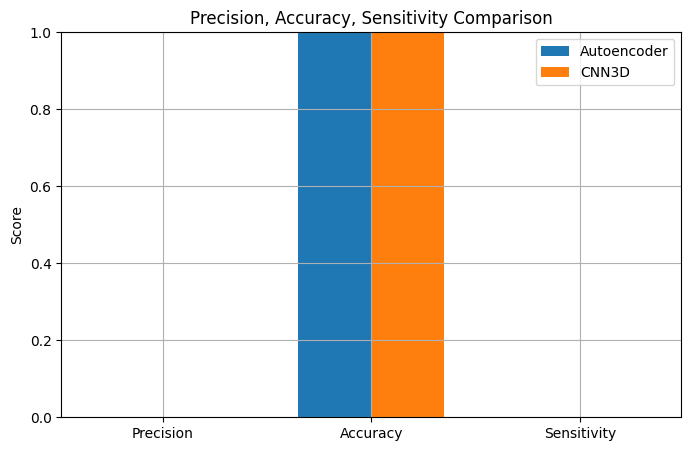

In [69]:
# Валидиране, сравнение и визуализация
ae_metrics = validate_segmentation(models["autoencoder"]["model"], val_loader, device)
cnn_metrics = validate_segmentation(models["cnn3d"]["model"], val_loader, device)

print("Autoencoder PAS:", ae_metrics)
print("CNN3D PAS:", cnn_metrics)

labels = ['Precision', 'Accuracy', 'Sensitivity']
ae_vals = [ae_metrics['precision'], ae_metrics['accuracy'], ae_metrics['recall']]
cnn_vals = [cnn_metrics['precision'], cnn_metrics['accuracy'], cnn_metrics['recall']]

x = np.arange(len(labels))
width = 0.35

plt.figure(figsize=(8, 5))
plt.bar(x - width/2, ae_vals, width, label='Autoencoder')
plt.bar(x + width/2, cnn_vals, width, label='CNN3D')
plt.ylabel("Score")
plt.title("Precision, Accuracy, Sensitivity Comparison")
plt.xticks(x, labels)
plt.ylim(0, 1)
plt.legend()
plt.grid(True)
plt.show()

In [70]:
# Сравнителни диаграми на FP, FN, TP, TN 

# Помощни функции
def compute_confusion_elements(pred, target, threshold=0.5):
    pred = torch.sigmoid(pred)
    pred = center_crop_to_target(pred, target)

    pred_bin = (pred > threshold).float()
    target_bin = (target > threshold).float()

    TP = (pred_bin * target_bin).sum().item()
    TN = ((1 - pred_bin) * (1 - target_bin)).sum().item()
    FP = (pred_bin * (1 - target_bin)).sum().item()
    FN = ((1 - pred_bin) * target_bin).sum().item()

    return TP, FP, FN, TN

def evaluate_model_confusion(model, dataloader):
    model.eval()
    TP, FP, FN, TN = 0, 0, 0, 0

    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            output = torch.sigmoid(model(x))
            output = center_crop_to_target(output, y)

            tp, fp, fn, tn = compute_confusion_elements(output, y)
            TP += tp
            FP += fp
            FN += fn
            TN += tn

    return {'TP': TP, 'FP': FP, 'FN': FN, 'TN': TN}

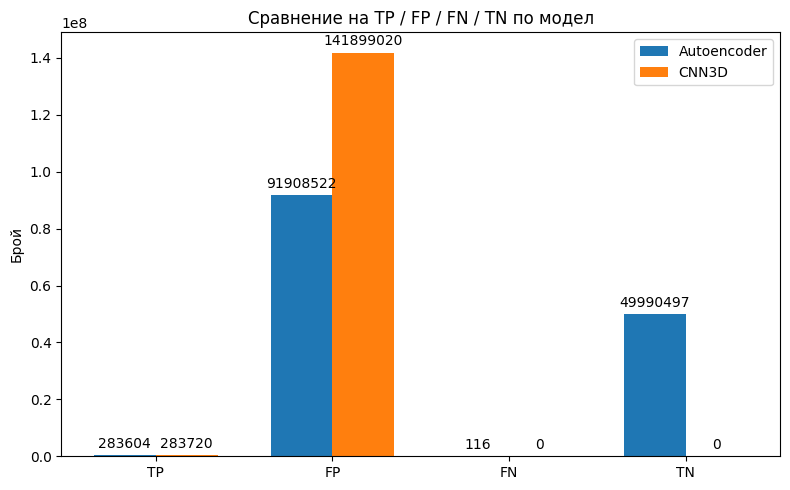

In [71]:
# Визуализация
conf_auto = evaluate_model_confusion(models["autoencoder"]["model"], val_loader)
conf_cnn3d = evaluate_model_confusion(models["cnn3d"]["model"], val_loader)

labels = ['TP', 'FP', 'FN', 'TN']
auto_vals = [conf_auto[l] for l in labels]
cnn_vals = [conf_cnn3d[l] for l in labels]

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(8, 5))
rects1 = ax.bar(x - width/2, auto_vals, width, label='Autoencoder')
rects2 = ax.bar(x + width/2, cnn_vals, width, label='CNN3D')

ax.set_ylabel('Брой')
ax.set_title('Сравнение на TP / FP / FN / TN по модел')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Добавяне на стойности върху стълбовете
def add_labels(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{int(height)}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(rects1)
add_labels(rects2)

plt.tight_layout()
plt.show()  